# Simulate an Acrobot system

Ref: http://underactuated.mit.edu/acrobot.html#section1

In [ ]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

In [ ]:
using Distributions
using DifferentialEquations
using Plots
default(label="", grid=false, margin=10Plots.pt)

In [6]:
# Dynamical parameters
m1 = 1 # kg
m2 = 1 # kg
l1 = 1 # m
l2 = 1 # m
G = 9.81 # N or kg*m / s^2

# Populate dictionary
sysparams = Dict()
sysparams[:m1] = m1
sysparams[:m2] = m2
sysparams[:l1] = l1
sysparams[:l2] = l2;

In [11]:
function dynamics(z_kmin1, u_k; Δt=0.1, gravity=9.81, sysparams=Dict(:m1=>1.0, :m2=>1.0, :l1=>1.0, :l2=>1.0))
    
    # Extract previous state
    θ1, θ2, dθ1, dθ2 = z_kmin1
#     println("   z $z_kmin1")
    
    # Extract dynamical params
    m1 = sysparams[:m1]
    m2 = sysparams[:m2]
    l1 = sysparams[:l1]
    l2 = sysparams[:l2]
    
    # Inverse mass matrix
    iMq11 =  l2^2
    iMq12 = -l2^2 - l1 * l2 * cos(θ2)
    iMq21 = iMq12
    iMq22 = (m1/m2) * l1^2 + l1^2 + l2^2 + 2 * l1 * l2 * cos(θ2)
    iMq = 1/(m2 * l1^2 * l2^2 * ((m1/m2) + sin(θ2)^2)) * [iMq11 iMq12; iMq21 iMq22]
    
    # Coriolis matrix
    Cqdq11 = 0
    Cqdq12 = -4dθ1 - 2dθ2
    Cqdq21 = 2dθ1 + dθ2
    Cqdq22 = -dθ1
    Cqdq = 0.5 * m2 * l1 * l2 * sin(θ2) * [Cqdq11 Cqdq12; Cqdq21 Cqdq22]
    
    # Effect of gravity
    τgq1 = (m1/m2) * l1 * sin(θ2) + l1 * sin(θ1) + l2 * sin(θ1 + θ2)
    τgq2 = l2 * sin(θ1 + θ2)
    τgq = -gravity * m2 * [τgq1; τgq2]
    
    # Control matrix
    B = [1 0; 0 1]
    
    # Transition
    z_k = z_kmin1 + Δt*[dθ1; dθ2; -iMq*Cqdq*[dθ1, dθ2] + iMq*τgq] + Δt*[0;0; iMq*B*[0, u_k]]
    
    return z_k
end

dynamics (generic function with 1 method)

In [12]:
# Time horizon
T = 100

# Sampling time step
Δt = 0.01

# Policy
u_ = zeros(T)

# Keep track of states
z_ = zeros(T,4)

# Initial state
z_[1,:] = [0, 0, 0.1, 0.1]

for k = 2:T
   
    # Evolve
    z_[k,:] = dynamics(z_[k-1,:], u_[k]; gravity=G, sysparams=sysparams)
    
end

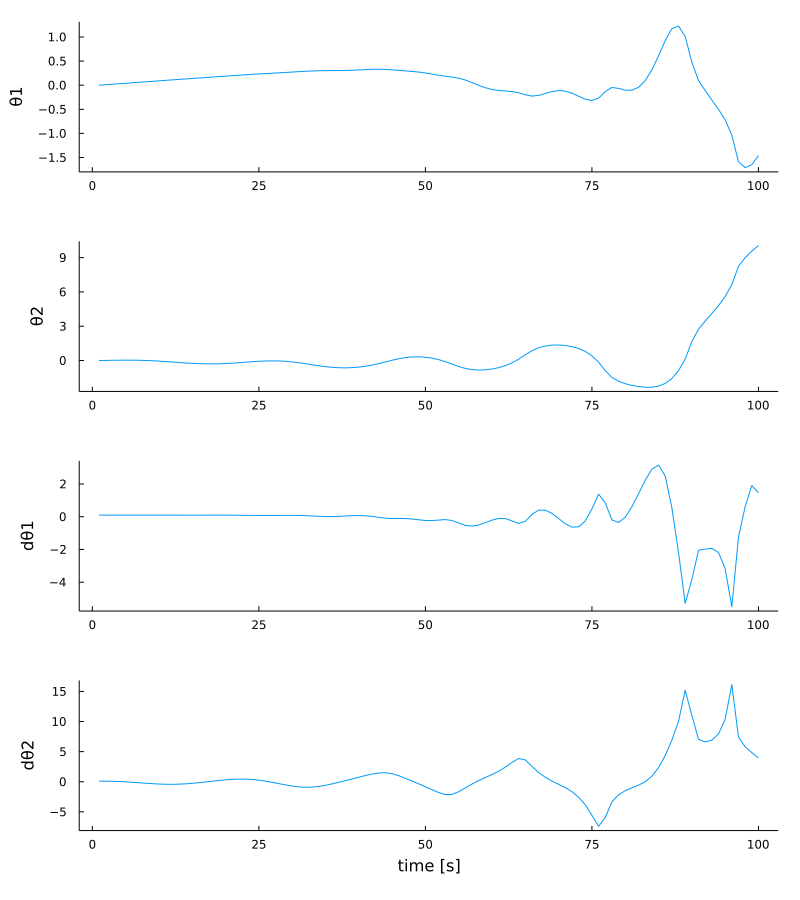

In [17]:
p101 = plot(1:T, z_[:,1], ylabel="θ1")
p102 = plot(1:T, z_[:,2], ylabel="θ2")
p103 = plot(1:T, z_[:,3], ylabel="dθ1")
p104 = plot(1:T, z_[:,4], ylabel="dθ2", xlabel="time [s]")
plot(p101, p102, p103, p104, layout=(4,1), size=(800,900))